# High Frequency Crpyto Trading Strategy
## FINM 33150 - Quant Trading Strategies (Winter 2024)

- Hanlu Ge 12455343 
- Junyuan liu 12449224 
- Xianjie Zhang 12452985
- Yong Li 12459425

# Table of Contents
- Introduction
- Data Preprocessing
- Data Analysis: Bitcoin & all market
- Strategy Methodology

# 1. Introduction

We selected the crypto market as our research focus due to its unique structural characteristics and trading dynamics, which differentiate it from traditional financial markets. Several key factors make crypto an ideal environment for high-frequency trading (HFT) research:

- High Volatility & Trading Opportunities
- 24/7 Trading & Market Microstructure
- Fragmented Market & Arbitrage Potential
- Deep Order Books & High Liquidity in Major Pairs
- Advancements in Infrastructure & API Access
- Evolving Regulatory Landscape & Institutional Involvement


This project aims to construct a multi-strategy integrated quantitative trading model based on high-frequency sampled cryptocurrency data, thereby achieving controlled risk and stable returns under backtesting conditions. The research team has collected and analyzed five-minute interval data for 178 cryptocurrencies, conducting in-depth exploratory analysis and statistical feature extraction to systematically compute technical indicators and liquidity factors. Subsequently, the project will develop sub-strategies focusing on (1) decision-tree predictions using high-dimensional technical indicators, (2) identification of short-term price jumps, and (3) refined technical indicators. These sub-strategies will then be combined through deterministic methods such as sliding windows and ensemble voting, thereby consolidating signals produced under various market conditions. The performance of this integrated model, in terms of both risk and returns, will be assessed via multidimensional backtesting and sensitivity analyses, confirming its feasibility and scholarly significance for achieving robust trading in highly volatile and noisy cryptocurrency markets.

# 2. Data Overview and Preprocessing

In this project, we use minute-level of cryptocurrency data from Binance exchange. The data is collected from 2022-01-01 to 2024-12-31 and for simplicity, we only consider the crypto traded in USD.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import os

## 2.1 Filter the ticker data completeness

In [41]:
# data_dir = r"./CryptoData1"
data_dir = r"./data/cpt_5min/k_data"

# data quality threshold
threshold = 315269
# only load the files that end with USD.pkl
pkl_files = [f for f in os.listdir(data_dir)]
# Modified to reset index for each DataFrame before concatenation
data_dict = {}
for file in pkl_files:
    df = pd.read_pickle(os.path.join(data_dir, file))
    # filter out the data that is not complete
    if df.shape[0] == threshold:
        data_dict[file] = df.assign(
            ticker=file.replace('USDT.pkl', '')
        ).reset_index()

combined_df = pd.concat(data_dict.values(), ignore_index=True)
combined_df.head()

,date,open,high,low,close,preclose,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,ticker
0,2021-12-31 16:00:00,2.489,2.490,2.489,2.490,NaN,55.8,1640966699999,138.92590000,2,55.80000000,138.92590000,0,1INCH
1,2021-12-31 16:05:00,2.490,2.490,2.490,2.490,2.490,0.0,1640966999999,0.00000000,0,0.00000000,0.00000000,0,1INCH
2,2021-12-31 16:10:00,2.479,2.479,2.479,2.479,2.490,5.0,1640967299999,12.39500000,1,5.00000000,12.39500000,0,1INCH
3,2021-12-31 16:15:00,2.479,2.479,2.479,2.479,2.479,0.0,1640967599999,0.00000000,0,0.00000000,0.00000000,0,1INCH
4,2021-12-31 16:20:00,2.479,2.479,2.479,2.479,2.479,0.0,1640967899999,0.00000000,0,0.00000000,0.00000000,0,1INCH


**Columns Description:**

- **date**: The datetime marking the start of a 5-minute interval.
- **open**: The opening price.
- **high**: The highest price.
- **low**: The lowest price.
- **close**: The closing price.
- **preclose**: The previous interval's closing price (calculated as `preclose = close.shift(1)`).
- **volume**: The total trading volume.
- **close_time**: The timestamp indicating the end of the 5-minute interval.
- **quote_asset_volume**: The traded volume measured in the quote asset during the 5-minute interval.
- **number_of_trades**: The total number of trades executed during the 5-minute interval.
- **taker_buy_base_asset_volume**: The volume of the base asset bought by takers.
- **taker_buy_quote_asset_volume**: The volume of the quote asset bought by takers.
- **ignore**: A placeholder column with no specific use.
- **ticker**: The cryptocurrency ticker.

## 2.1 Filter the ticker by number of trades

drop the ticker with low volume with the following steps:

1. Calculate the average volume for each ticker.
2. Filter the ticker with average number of trades less than 1, that is, at least 1 trade in the five minutes interval
3. Drop the ticker with low volume.

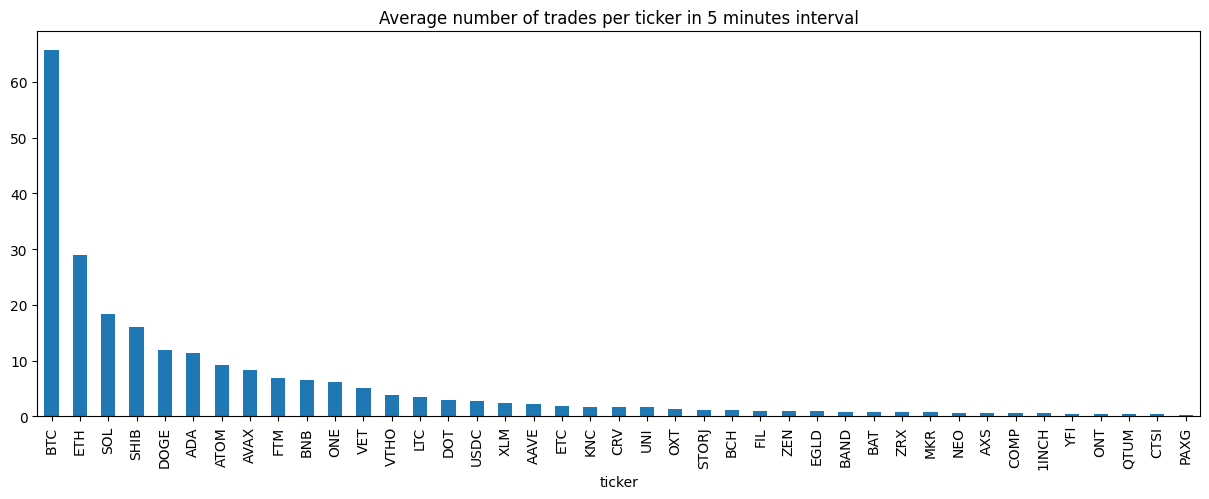

In [42]:
combined_df.groupby('ticker')['number_of_trades'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))
plt.title('Average number of trades per ticker in 5 minutes interval')
plt.show()

In [43]:
# filter out the data that has less than 0.05 quantile of the mean volume
filtered_df1 = combined_df[combined_df['ticker'].map(combined_df.groupby('ticker')['number_of_trades'].mean() > 1)].reset_index(drop=True)
print(f"Remain tickers after volume filter: {filtered_df1['ticker'].nunique()}")

Remain tickers after volume filter: 25


## 2.2 Filter the ticker of quantile of return

In [44]:
filtered_df1['ret'] = filtered_df1.groupby('ticker')['close'].pct_change()
res = filtered_df1.groupby('ticker')['ret'].describe().sort_values('75%', ascending=False)
res

,count,mean,std,min,25%,50%,75%,max
ticker,,,,,,,,
SOL,315268.0,6.199572e-06,0.003465,-0.109259,-0.001303,0.0,0.001312,0.177653
SHIB,315268.0,4.331039e-06,0.003450,-0.107133,-0.001046,0.0,0.001083,0.111365
ADA,315268.0,2.319111e-06,0.002769,-0.059805,-0.000917,0.0,0.000944,0.054610
DOGE,315268.0,7.128609e-06,0.003254,-0.084370,-0.000864,0.0,0.000907,0.120471
ETH,315268.0,1.871810e-06,0.002139,-0.052219,-0.000785,0.0,0.000800,0.081958
AVAX,315268.0,2.132986e-06,0.003366,-0.194893,-0.000715,0.0,0.000737,0.112780
BNB,315268.0,3.277732e-06,0.002183,-0.052357,-0.000664,0.0,0.000725,0.080841
BTC,315268.0,3.499931e-06,0.001694,-0.043487,-0.000659,0.0,0.000670,0.048632
ATOM,315268.0,3.556736e-07,0.003340,-0.174401,-0.000208,0.0,0.000262,0.175662


In [45]:
ticker_list = res[res['75%'] > 0].index
filtered_df2 = filtered_df1[filtered_df1['ticker'].isin(ticker_list)].reset_index(drop=True)
print(f"Remain tickers after return filter: {filtered_df2['ticker'].nunique()}")

Remain tickers after return filter: 11


The tickers left are:

| ADA  | ATOM | AVAX |  BNB | BTC  |
|------|------|------|------|------|
| **DOGE**  | **ETH**  | **LTC**  |  **SHIB** | **SOL** |
| **VETI**  |   |      |      |      |

## 3. Data Analysis - Single Asset analysis - BTC

Bitcoin is the most popular cryptocurrency and has the highest market capitalization. We take Bitcoin as an example to analyze the market dynamics and trading patterns in the crypto market.

### 3.1 Descriptive Statistics

In [47]:
BTCUSD = filtered_df2[filtered_df2['ticker'] == 'BTC'].reset_index(drop=True)
BTCUSD['date'] = pd.to_datetime(BTCUSD['date'])
BTCUSD = BTCUSD[(BTCUSD['date'] >= '2022-01-01') & (BTCUSD['date'] <= '2024-12-31')].reset_index(drop=True)
data = BTCUSD.drop(columns=['ignore'])
data.describe()

,date,open,high,low,close,preclose,volume,close_time,number_of_trades,ret
count,315173,315173.000000,315173.000000,315173.000000,315173.000000,315173.000000,315173.000000,3.151730e+05,315173.000000,315173.000000
mean,2023-07-02 09:10:56.744073216,40939.216608,40972.906137,40903.643842,40939.270568,40939.125330,2.670713,1.688289e+12,65.763911,0.000004
min,2022-01-01 00:00:00,15596.550000,15630.640000,15486.740000,15593.390000,15593.390000,0.000000,1.640995e+12,0.000000,-0.043487
25%,2022-10-01 14:35:00,24747.640000,24780.150000,24711.920000,24747.160000,24747.160000,0.034038,1.664635e+12,10.000000,-0.000659
50%,2023-07-02 11:50:00,34980.940000,35025.380000,34949.920000,34979.880000,34979.880000,0.297510,1.688299e+12,29.000000,0.000000
75%,2024-04-01 01:55:00,58993.790000,59036.560000,58940.240000,58998.860000,58997.150000,2.059479,1.711937e+12,75.000000,0.000670
max,2024-12-30 16:00:00,108244.530000,138070.000000,107915.260000,108244.540000,108244.540000,555.412318,1.735575e+12,4091.000000,0.048632
std,NaN,20640.382815,20656.693320,20623.088387,20640.789086,20640.590922,7.398777,2.730534e+10,112.397810,0.001694


1. **Price Range and Volatility**  
   - The **open** price spans from around **15,596.55** to **108,244.53**. This broad range indicates that our dataset covers multiple market phases, from relatively lower BTC prices to periods of significant price escalation.
   - The **average open** is approximately **40,940.95**, with a standard deviation of **20,637.48**, highlighting substantial volatility that could present opportunities for HFT strategies.

2. **Volume Dynamics**  
   - The **mean volume** is about **2.67**, but it spikes up to **555.41**, indicating that there are periods of high trading activity along with low-volume intervals. This fluctuation in volume can impact the effectiveness of HFT strategies, as liquidity conditions can vary significantly.

3. **Trading Frequency**  
   - On average, the **number of trades** per interval is around **65.76**. However, the maximum observed is **4,091**, illustrating large swings in how frequently trades occur. HFT systems often do well in such environments, as higher trade counts enable rapid entry and exit.

4. **Data Coverage**  
   - The **date** ranges from **2022-01-01** to **2024-12-30**, covering a substantial period—likely spanning multiple years of BTC price action. This  allows for robust backtesting across different market conditions

### Implications for HFT Strategy Testing

- **Volatile Environment**: High volatility  can create frequent arbitrage opportunities.
- **Liquidity Events**: Number of trades indicates that generally the liquidity is high, which can be used by HFT strategies.

### 3.2 Missing Value Check

In [48]:
data.set_index('date', inplace=True)
print(data.isnull().sum())
data = data.fillna(0)

open                            0
high                            0
low                             0
close                           0
preclose                        0
volume                          0
close_time                      0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
ticker                          0
ret                             0
dtype: int64


The data equality is generally high, with **no missing values** in the dataset. This is crucial for HFT strategies, as missing data can lead to inaccurate signals and execution errors.

### 3.3 BTC 5-Minute Close Price 

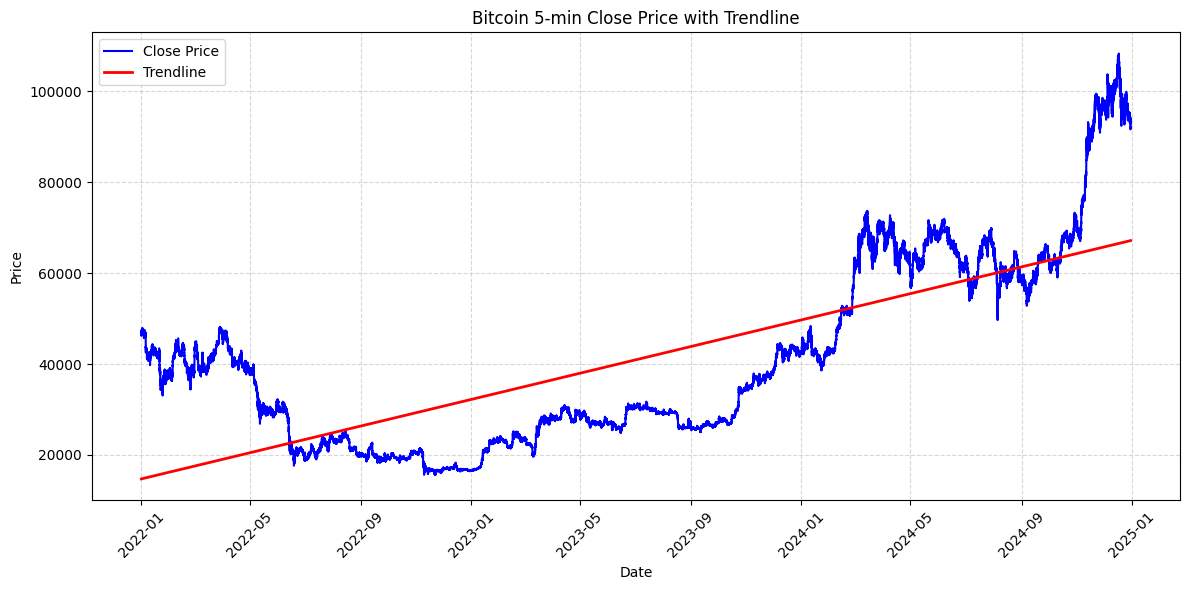

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], linestyle='-', color='blue', label='Close Price')

x = mdates.date2num(data.index.to_pydatetime())
y = data['close'].values

coeffs = np.polyfit(x, y, deg=1)
trend = np.poly1d(coeffs)
trend_y = trend(x)

plt.plot(data.index, trend_y, color='red', linewidth=2, label='Trendline')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin 5-min Close Price with Trendline')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

The chart above shows the 5-minute close price of Bitcoin from early **2022** to early **2025**, overlaid with a **linear trendline** (in red). Key observations include:

1. **Early Price Drop**  
   - In early 2022, BTC falls from about 40k–45k down to around 15k. This drop is often called a “crypto winter.”  
   - Big events (like the Terra/Luna crash and some exchanges failing) plus world economic issues push prices lower.

2. **Recovery and Upward Trend**  
   - After hitting around 15k in mid-2022, the price starts to rise. By late 2024 and early 2025, it is well above its level at the start of 2022.  
   - The red trend line on the chart tilts upward, showing that overall, the price moved higher over time.

3. **Price Swings and Trading Chances**  
   - Even when the price is falling, there are still quick ups and downs, which can be risky but also offer short-term trading chances.  
   - As the price goes up again, these swings continue, giving room for short-term or high-frequency trading strategies to benefit from fast price moves.


### 3.4 Volume Trend Visualization

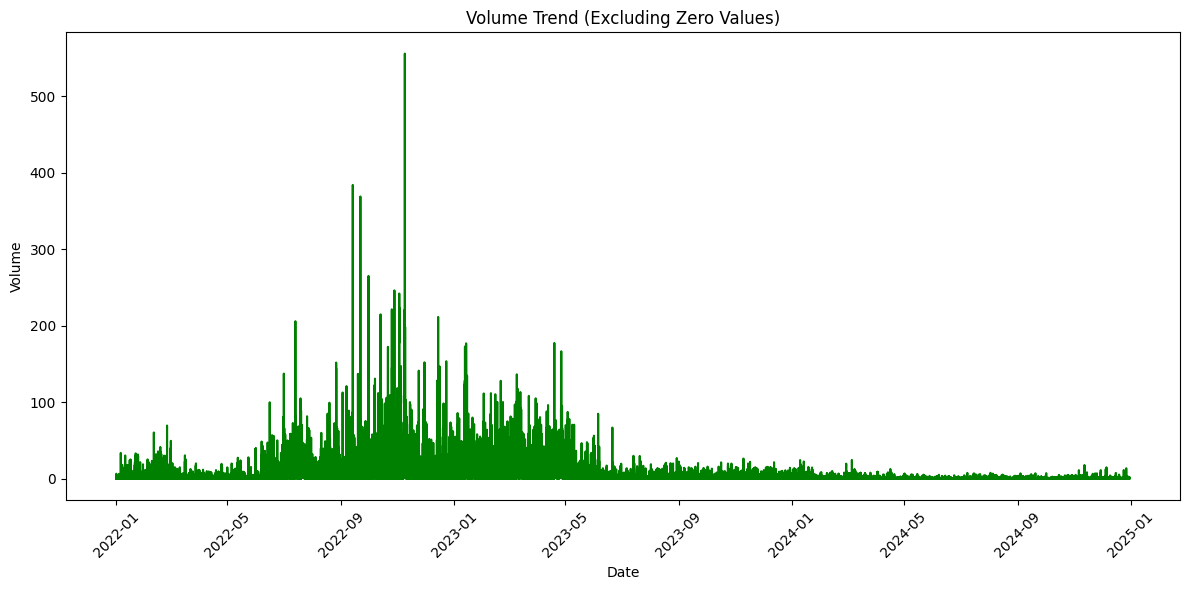

In [50]:
filtered_volume = data[data['volume'] != 0]
plt.figure(figsize=(12, 6))
plt.plot(filtered_volume.index, filtered_volume['volume'], color='green')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume Trend (Excluding Zero Values)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The chart above illustrates Bitcoin’s trading volume on a 5-minute interval from **2022** through early **2025**, excluding periods where volume was zero. Key points include:

1. **Big Volume Spikes in Mid- to Late-2022**  
   - We see many tall peaks around this period, with some going above 500 units.  
   - These big jumps often happened during major events like the Terra/Luna crash and the FTX crisis.

2. **Lower Volume After Late-2022**  
   - Once these events passed, volume fell and stayed low through 2023 and 2024.  
   - Even though the price later climbed, trading activity stayed calmer than before.

3. **Impact on Trading**  
   - Sudden changes in volume can bring both chances for profit and extra risk.  
   - High-frequency traders need to be ready to handle quick surges or drops in activity.  


### 3.5 Visualization of Close Price Rate of Change

This chart shows how the BTC price changes from one 5-minute interval to the next. Most of the time, changes (returns) stay close to zero, suggesting that many small moves happen around the average. But we also see big spikes—both up and down—which means the market can swing more than a normal “bell curve” would predict. These big jumps often come from fast shifts in trading activity or breaking news, highlighting the extra volatility in crypto markets.


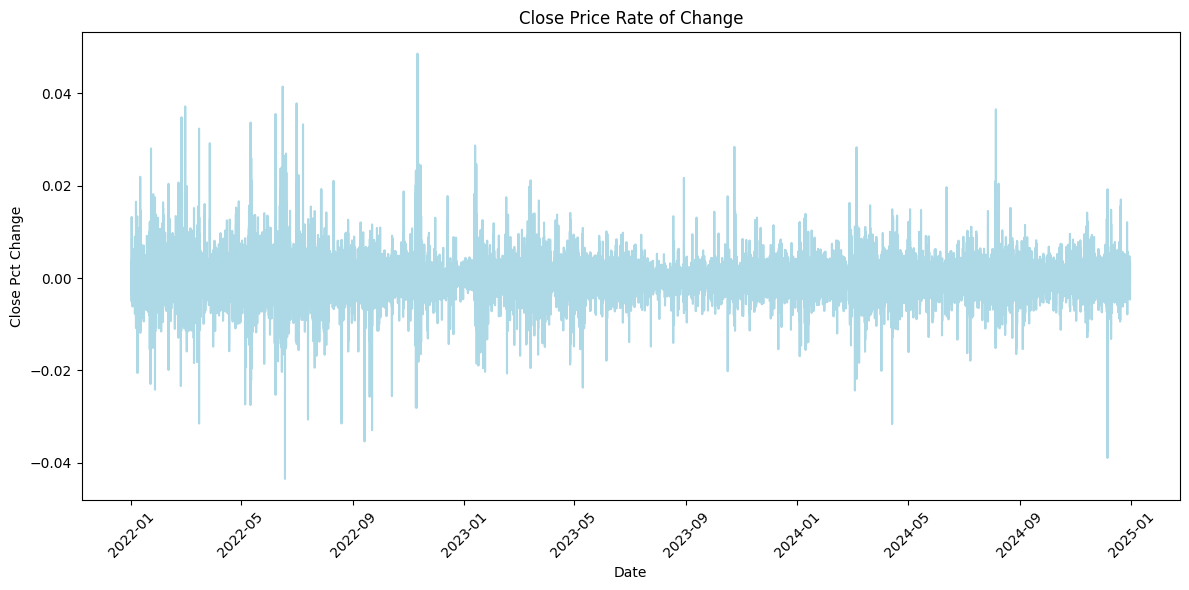

In [51]:
data['close_pct_change'] = data['close'].pct_change()
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close_pct_change'], color='lightblue')
plt.xlabel('Date')
plt.ylabel('Close Pct Change')
plt.title('Close Price Rate of Change')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.6 Data Distribution

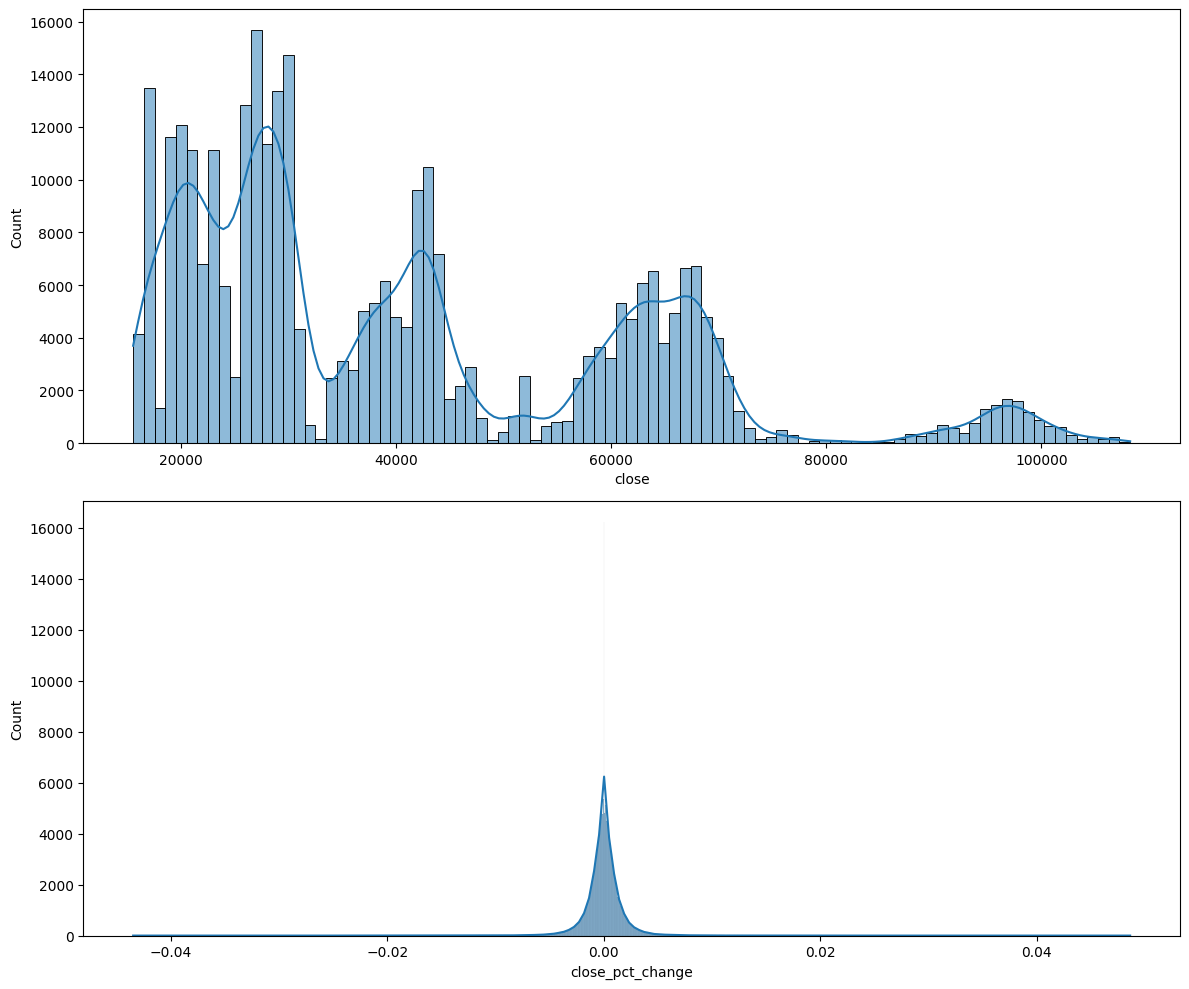

In [52]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(['close', 'close_pct_change']):
    plt.subplot(2, 1, i+1)
    sns.histplot(data[col], kde=True)
plt.tight_layout()
plt.show()

The top histogram shows **BTC’s closing prices** from 2022 to early 2025. There are several peaks:
- A main cluster around **15k–20k**  
- Another cluster near **35k–45k**

These clusters suggest that market sentiment shifted at different times over the sample period.

The bottom histogram displays the **five-minute returns**. Most returns center closely around **0%**, but the “fat tails” show that big moves do happen more often than a normal distribution would predict—common in crypto markets.

Finally, there are **no major gaps or errors** in the data, implying it is reliable for deeper analysis and for building or testing trading strategies.

### 3.7 Autocorrelation Analysis

We checked how each 5-minute BTC return relates to its past values by looking at the **partial autocorrelation** up to 80 steps back (lags). Here’s what we found:

- **One Big Spike at Lag 0**: This just shows the return is perfectly correlated with itself at the same point in time, which is expected.  
- **No Noticeable Autocorrelation After Lag 0**: All other lags stay near zero, meaning the returns have little to no “memory” of past changes.  

**if BTC’s price went up or down in one 5-minute interval**, it does not give much clue about what will happen in the next few intervals. This lines up with the idea that crypto markets often behave in a way where recent price movements do **not** strongly predict future ones.


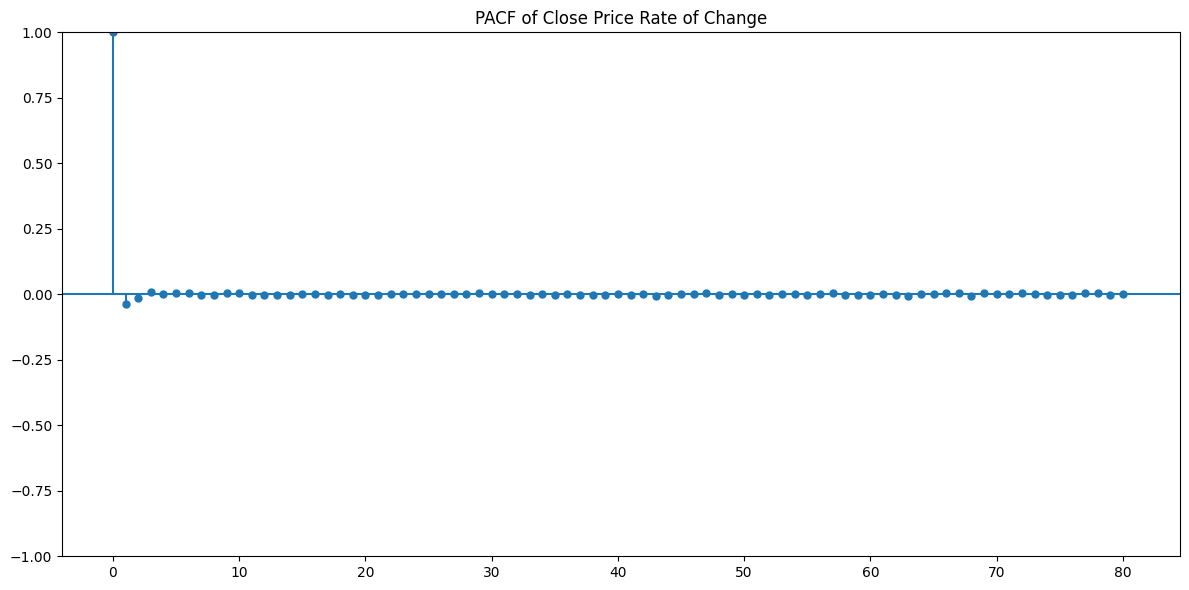

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(data['close_pct_change'].dropna(), lags=80, ax=ax)
plt.title('PACF of Close Price Rate of Change')
plt.tight_layout()
plt.show()

# 4. Data Analysis - Multiple Cryptos

To examine the correlation among different cryptocurrencies’ close price movements during the sample period, we selected the five with the highest average trading volume, along with Bitcoin, for the following comparative analysis.

## 4.1 Return and Cumulative Return Visualization

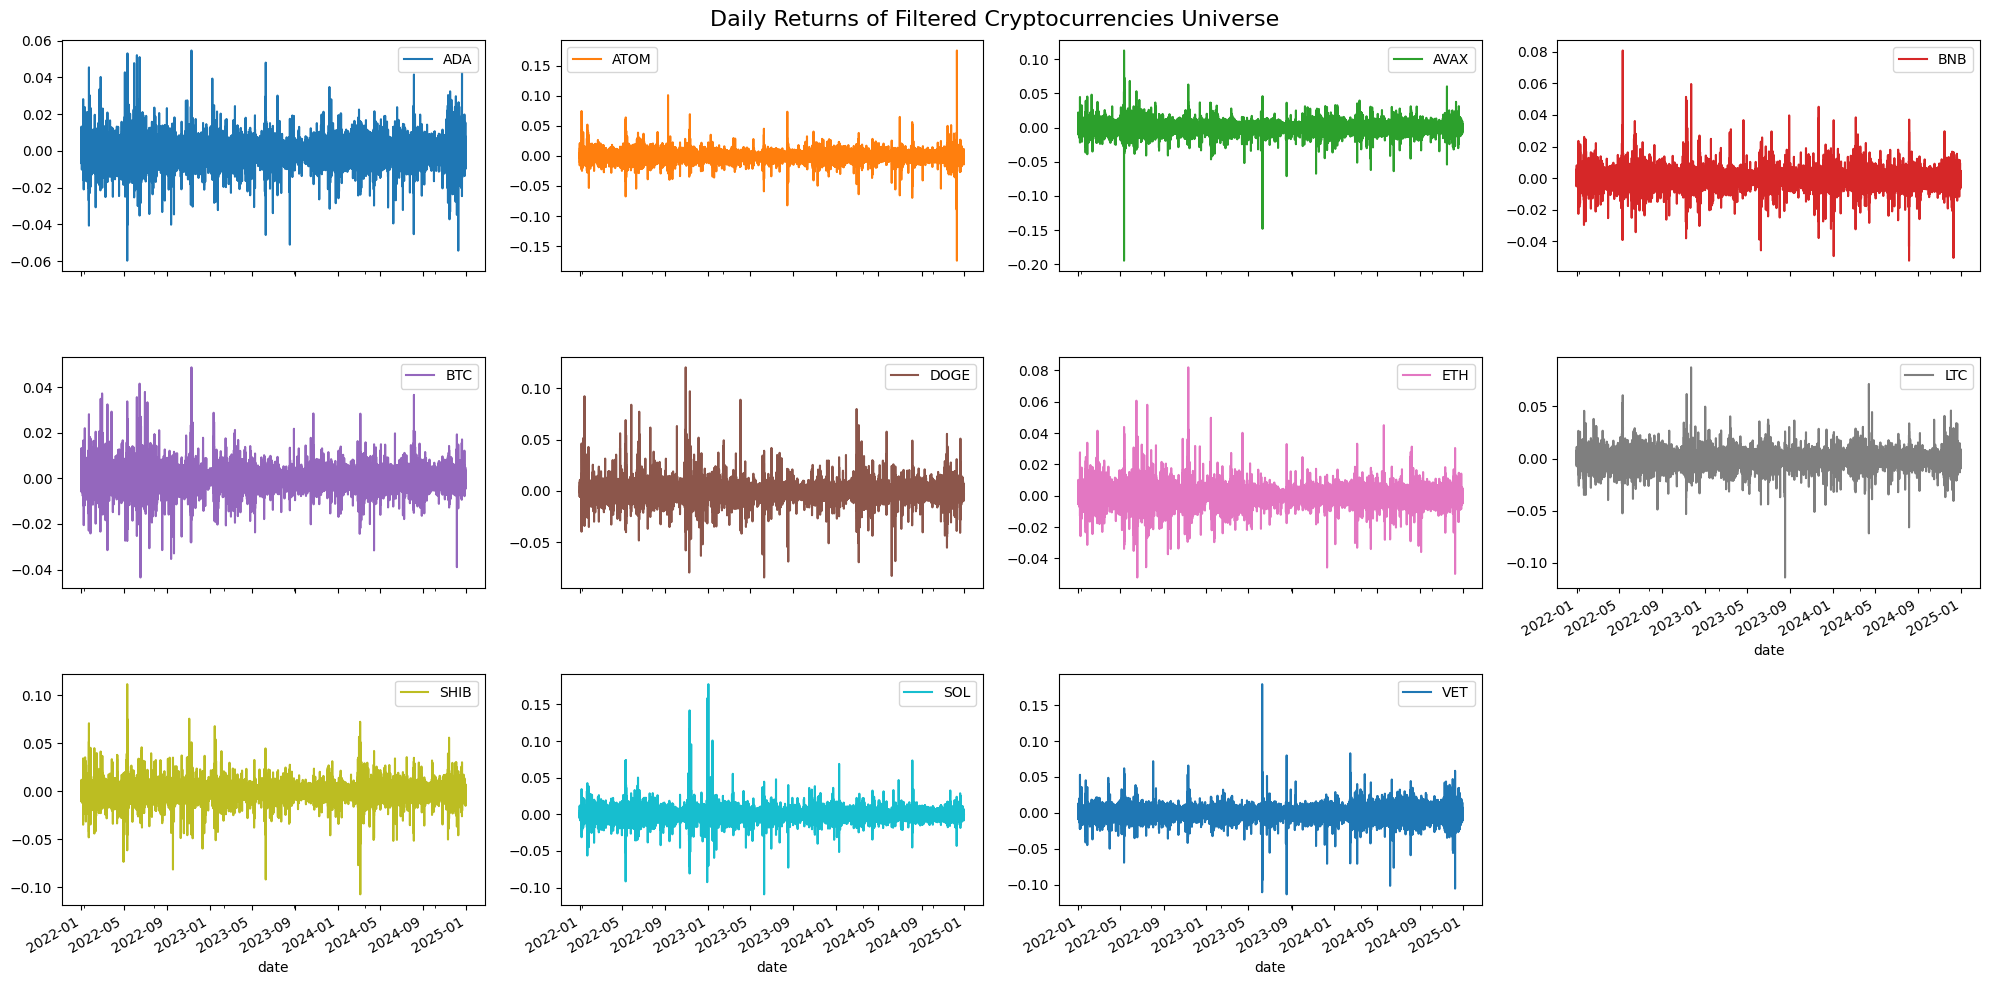

In [59]:
crypto_ret = filtered_df2.pivot(index='date', columns='ticker', values='ret') 
crypto_ret.plot(subplots=True, layout=(3, 4), figsize=(20, 10), sharex=True)
plt.suptitle('Daily Returns of Filtered Cryptocurrencies Universe',fontsize=16) 
plt.tight_layout()  
plt.subplots_adjust(top=0.95) 
plt.show() 

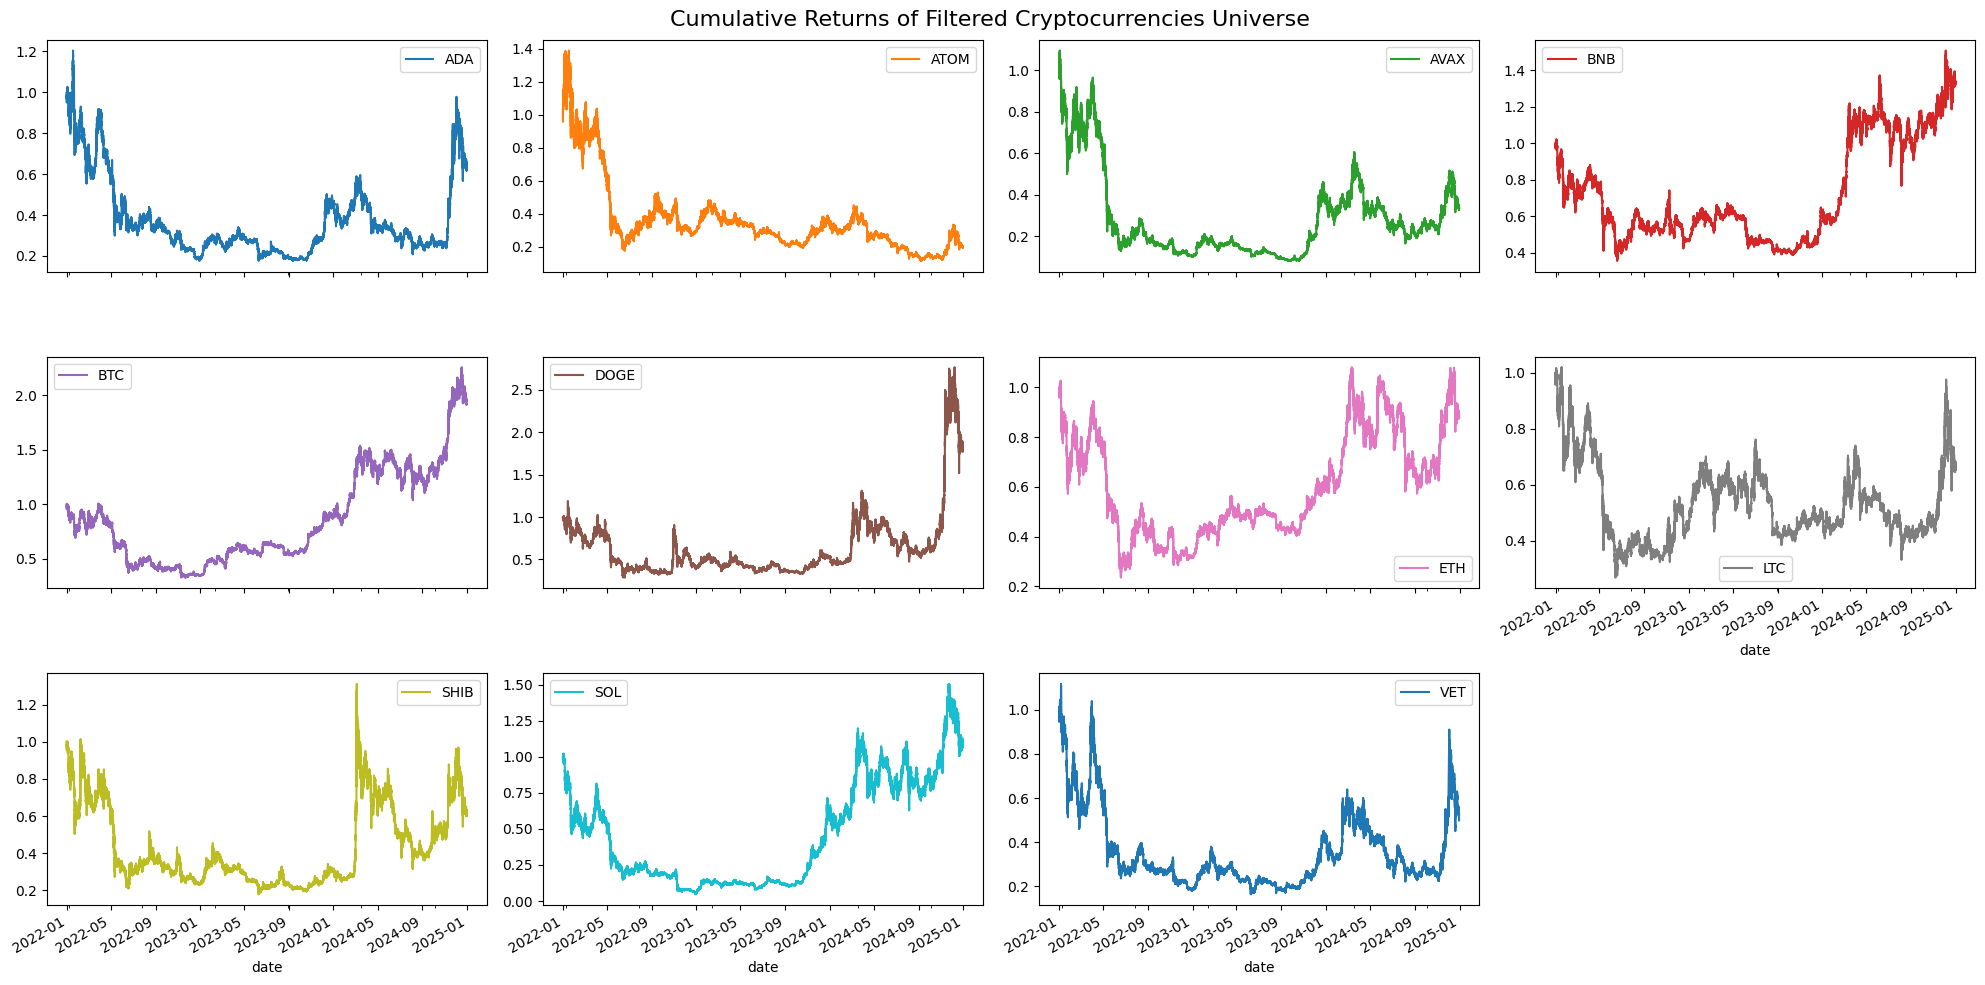

In [60]:
(crypto_ret+1).cumprod().plot(subplots=True, layout=(3, 4), figsize=(20, 10), sharex=True)
plt.suptitle('Cumulative Returns of Filtered Cryptocurrencies Universe',fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

## 4.2 Correlation Analysis

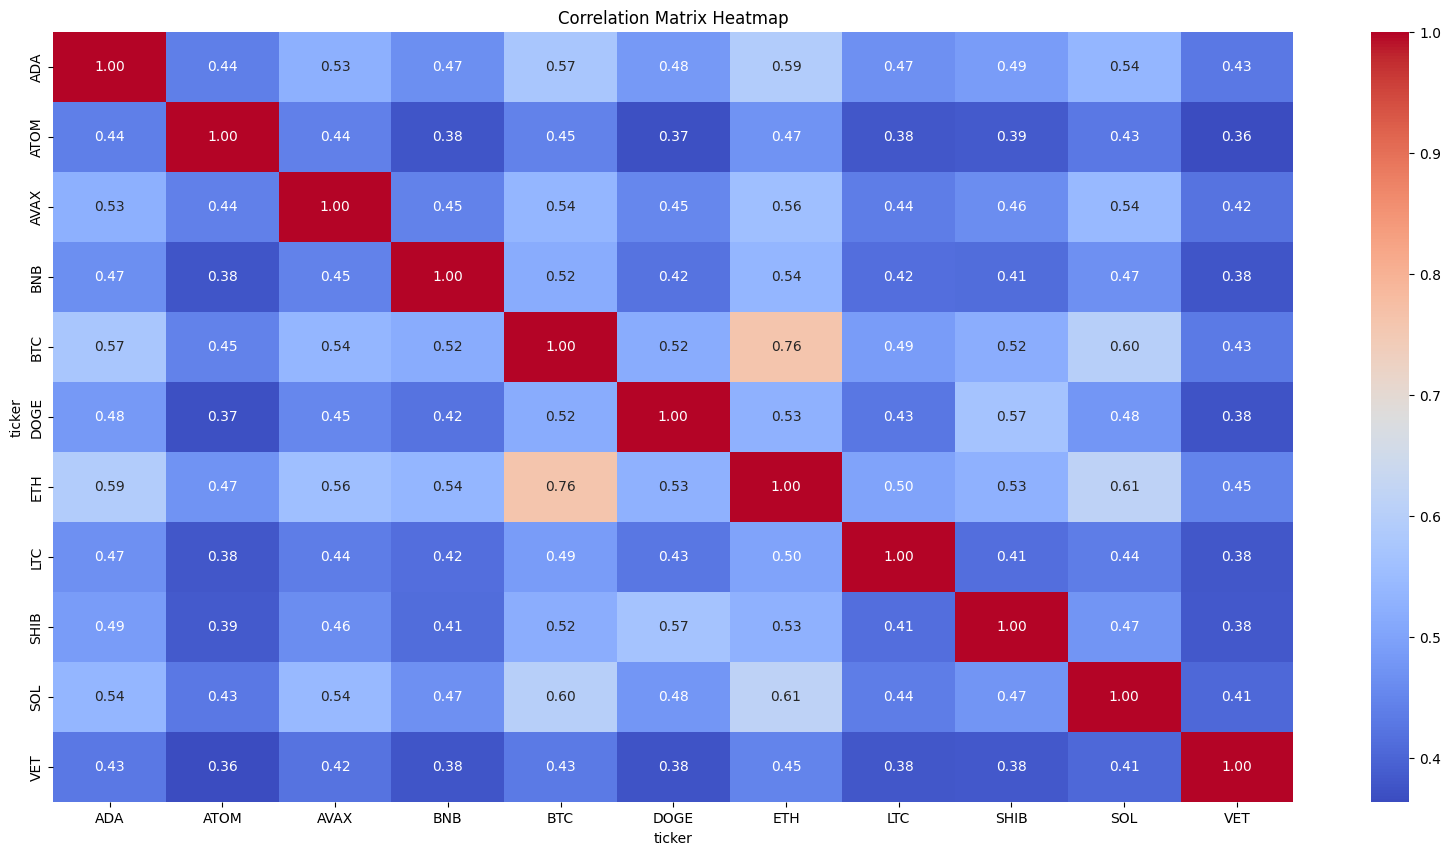

In [61]:
corr_matrix = crypto_ret.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

**Overall Pattern**  
Most of the cryptocurrencies in this heatmap show moderate to high positive correlations with one another. This is typical in crypto markets, where broad market sentiment often moves prices across different assets.

**High-Correlation Pairs**  
- **BTC and ETH** have one of the highest correlations (around **0.76**), suggesting that when Bitcoin’s price changes, Ethereum often follows suit.  
- **BTC and BNB** also display a relatively strong correlation (above **0.75**), indicating that BNB’s price movements are closely tied to Bitcoin’s dynamics.

**Moderate-Correlation Range**  
For many other pairs, correlations cluster between **0.50** and **0.70**. These moderate correlations suggest some shared market drivers, though there is still room for each coin to move independently.

**Implications for Diversification**  
Although correlations are not uniformly high, they are still significant enough that holding multiple coins may not provide full diversification. During large market moves, most coins tend to be affected simultaneously.

**Conclusion**  
Overall, this correlation matrix shows that while specific pairs may have some distinctions, the crypto market generally moves in tandem. Investors seeking diversification should look for pairs with lower correlations, while keeping in mind that strong, market-wide movements can still impact most crypto assets at once.


# 5. Strategy Methodology
For the high-frequency trading strategy, we implement 3 sub-strategies:
- High-Dimensional Technical Indicators and Decision-Tree Classification
- Price Jump Detection and Liquidity Factor Utilization
- De-Trending and Dynamic Threshold Adjustments

And we combine these sub-strategies using ensemble voting and sliding windows to generate trading signals. The signals are then used to execute trades and manage positions in a controlled manner.

## 5.1 Introduction  
We selected the **crypto market** as our research focus due to its **unique structural characteristics** and **trading dynamics**, which differentiate it from traditional financial markets. Several key factors make crypto an ideal environment for **high-frequency trading (HFT) research**:  

- **High Volatility & Trading Opportunities**  
- **24/7 Trading & Market Microstructure**  
- **Fragmented Market & Arbitrage Potential**  
- **Deep Order Books & High Liquidity in Major Pairs**  
- **Advancements in Infrastructure & API Access**  
- **Evolving Regulatory Landscape & Institutional Involvement**  

### Initial Observations with RSI  
Our study begins with the **Relative Strength Index (RSI)**, a classic technical indicator. However, when applied to **high-frequency data**, we observed several critical issues:  

- **Extreme Volatility:** The high fluctuation of market data results in an **unstable RSI**, leading to excessive trading.  
- **Frequent Trades:** Rapid shifts in RSI values cause **overactive trading**, which can accumulate **significant transaction costs** and **losses**.  
- **False Signals in Extreme Events:** On **January 21, 2022**, a **sharp price drop** occurred, but the RSI falsely signaled a **buy opportunity**, leading to **substantial losses**.  

In [2]:
import pandas as pd
df = pd.read_pickle("data/cpt_5min/k_data/BTCUSD.pkl")

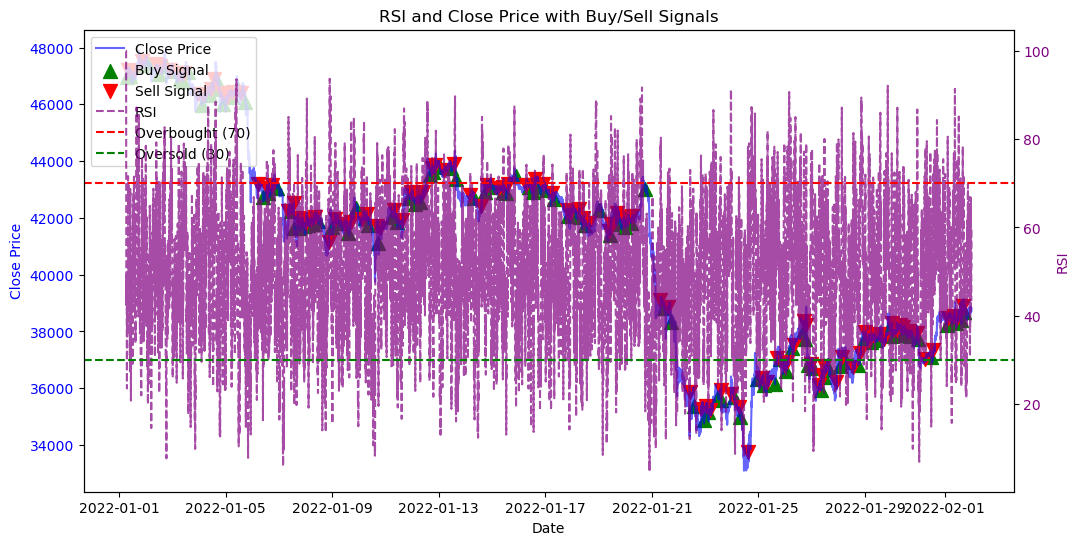

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_rsi(data, period=14):
    """Compute the Relative Strength Index (RSI) using EMA."""
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def backtest_rsi(data, period=14, rsi_buy=30, rsi_sell=70, initial_cash=10000):
    """Backtest an RSI strategy and record buy/sell points."""
    data = data.copy()
    data["RSI"] = calculate_rsi(data["close"], period)
    
    cash = initial_cash
    position = 0
    portfolio = []
    buy_signals = []
    sell_signals = []

    for i in range(len(data)):
        price = data["close"].iloc[i]
        rsi = data["RSI"].iloc[i]

        if rsi < rsi_buy and cash > 0:  # Buy condition
            position = cash / price
            cash = 0
            buy_signals.append((data.index[i], price))
        elif rsi > rsi_sell and position > 0:  # Sell condition
            cash = position * price
            position = 0
            sell_signals.append((data.index[i], price))

        portfolio_value = cash + (position * price)  # Track portfolio value
        portfolio.append(portfolio_value)

    data["Portfolio"] = portfolio
    return data, buy_signals, sell_signals

# Load the data
data = df.copy()

data = data[:'2022-2-01']

# Run the RSI backtest
result, buy_signals, sell_signals = backtest_rsi(data)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the closing price
ax1.plot(result.index, result["close"], label="Close Price", color="blue", alpha=0.6)
ax1.set_xlabel("Date")
ax1.set_ylabel("Close Price", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Plot buy/sell signals (only one legend entry for each)
if buy_signals:
    ax1.scatter(*zip(*buy_signals), marker="^", color="green", label="Buy Signal", s=100)
if sell_signals:
    ax1.scatter(*zip(*sell_signals), marker="v", color="red", label="Sell Signal", s=100)

# Add a secondary y-axis for RSI
ax2 = ax1.twinx()
ax2.plot(result.index, result["RSI"], label="RSI", linestyle="dashed", color="purple", alpha=0.7)
ax2.axhline(70, linestyle="--", color="red", label="Overbought (70)")
ax2.axhline(30, linestyle="--", color="green", label="Oversold (30)")
ax2.set_ylabel("RSI", color="purple")
ax2.tick_params(axis='y', labelcolor="purple")

# Merge legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Keep only one legend entry for Buy and Sell signals
legend_labels = {}
for handle, label in zip(handles1 + handles2, labels1 + labels2):
    if label not in legend_labels:
        legend_labels[label] = handle

ax1.legend(legend_labels.values(), legend_labels.keys(), loc="upper left")

plt.title("RSI and Close Price with Buy/Sell Signals")
plt.show()


To overcome these challenges, we propose an **improved research direction** focusing on optimizing high-frequency trading strategies.  

## Research Objectives  
To enhance the performance of high-frequency trading in crypto markets, our study will explore the following key areas:  

1. **Predicting Intraday Price Jumps**  
   - Develop methods to identify and predict **intraday price jumps** with high probability.  
   - Improve decision-making to reduce **strategy drawdowns** and optimize trade timing.  

2. **Adapting Classic Technical Indicators for High-Frequency Trading**  
   - Modify traditional indicators like RSI to **reduce noise** and enhance signal stability.  
   - Explore alternative smoothing techniques to prevent **excessive trading** due to high volatility.  

3. **Market Regime Adaptability**  
   - Design strategies that can **adjust dynamically** based on market conditions:  
     - **Trending markets (bull/bear trends)**  
     - **Range-bound (sideways) markets**  
   - Implement **adaptive risk management** to handle different volatility environments effectively.  


In [38]:
import importlib
import technical_indicators  

importlib.reload(technical_indicators)

from technical_indicators import TechnicalIndicators

In [39]:
tech_indicators = TechnicalIndicators(df)
df_with_indicators = tech_indicators.get_tech_indicators()

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to implement the trading strategy
def apply_trading_strategy(df):
    df = df.copy()

    # Initialize positions
    df['Signal_SMA'] = 0  
    df['Signal_EMA'] = 0  
    df['Signal_MACD'] = 0  
    df['Signal_Bollinger'] = 0 
    df['Signal_Stochastic'] = 0  
    df['Signal_RSI'] = 0  

    # Strategy 1: SMA Crossover
    df.loc[df['close'] > df['SMA_20'], 'Signal_SMA'] = 1  # Buy
    df.loc[df['close'] < df['SMA_20'], 'Signal_SMA'] = -1  # Sell

    # Strategy 2: EMA Trend
    df.loc[df['close'] > df['EMA_14'], 'Signal_EMA'] = 1  
    df.loc[df['close'] < df['EMA_14'], 'Signal_EMA'] = -1  

    # Strategy 3: MACD Crossover
    df.loc[df['MACD'] > df['Signal_Line'], 'Signal_MACD'] = 1  
    df.loc[df['MACD'] < df['Signal_Line'], 'Signal_MACD'] = -1  

    # Strategy 4: Bollinger Bands
    df.loc[df['close'] < df['Lower_BB'], 'Signal_Bollinger'] = 1  
    df.loc[df['close'] > df['Upper_BB'], 'Signal_Bollinger'] = -1  

    # Strategy 5: Stochastic Oscillator
    df.loc[(df['%K'] > df['%D']) & (df['%K'] < 20), 'Signal_Stochastic'] = 1  
    df.loc[(df['%K'] < df['%D']) & (df['%K'] > 80), 'Signal_Stochastic'] = -1  

    # Strategy 6: RSI Overbought/Oversold
    df.loc[df['RSI'] < 30, 'Signal_RSI'] = 1  
    df.loc[df['RSI'] > 70, 'Signal_RSI'] = -1  

    return df

# Apply the strategy
df_strategy = apply_trading_strategy(df_with_indicators)

In [41]:
import trading_signal  

importlib.reload(trading_signal)

from trading_signal import long_short_strategy
from trading_signal import long_only_strategy
from trading_signal import short_only_strategy

# Apply strategies
series_position_long_short = long_short_strategy(df_strategy['Signal_RSI'])
series_position_long_only = long_only_strategy(df_strategy['Signal_RSI'])
series_position_short_only = short_only_strategy(df_strategy['Signal_RSI'])

In [42]:
import importlib
import metrics  

importlib.reload(metrics)

from metrics import evaluate_strategy
from metrics import calculate_cumulative_asset

In [43]:
df_result = calculate_cumulative_asset(df_strategy["close"], series_position_long_short)

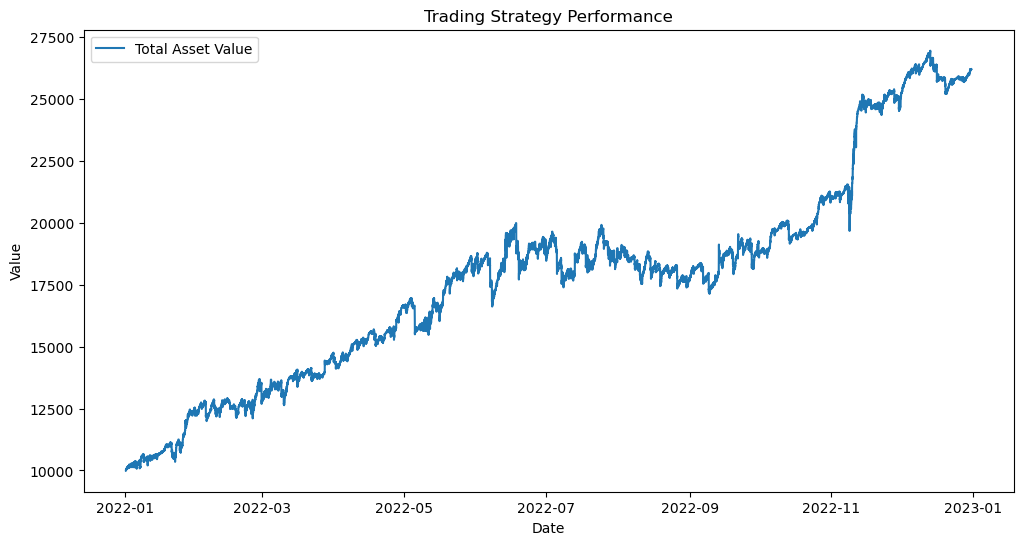

In [10]:
import matplotlib.pyplot as plt

# Plot Total Asset Value, Cash Balance, and Crypto Holdings Value
plt.figure(figsize=(12,6))

# Plot total asset value
plt.plot(df_result.index, df_result["Cumulative_Asset"], label="Total Asset Value")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Trading Strategy Performance")

# Show legend
plt.legend()

# Show the plot
plt.show()


In [11]:
evaluate_strategy(df_result, risk_free_rate=0.0)

{'Sharpe Ratio': 0.008261191976525868,
 'Max Drawdown (%)': -14.250509448344411,
 'Holding Win Rate (%)': 10.23782040886413,
 'Trading Win Rate (%)': 74.54873646209387,
 'Final Cumulative Return (%)': 161.92709237656717}

This chart illustrates the **performance of the RSI-based trading strategy**. The **cumulative asset value** shows a **clear upward trend**, indicating that the traditional RSI strategy has been able to generate **substantial returns**. However, the **high volatility** and **large drawdowns** observed throughout the period suggest that the strategy has a **high variance**, making its returns less stable.

### Key Observations:
1. **Consistent Growth with High Variance**:  
   - From early 2022 to November 2022, the cumulative asset value experienced **steady growth**, but with significant fluctuations and **multiple drawdowns**.
   - Between **July and September 2022**, the strategy entered a **consolidation phase** with increased volatility, possibly due to market conditions.
   - **After November 2022**, there was a **sharp increase** in asset value, which could be attributed to **market trends or improved strategy effectiveness in certain conditions**.

2. **High Drawdowns and Volatility**:  
   - The **strategy’s performance is inconsistent** across different periods, with **frequent fluctuations**.
   - The **high variance** suggests that the **risk-adjusted return (Sharpe ratio) is suboptimal** and needs improvement.

### Summary & Future Improvements

To construct a **higher Sharpe ratio strategy**, we will focus on the following three key approaches:

1. **Enhancing Signal Reliability with Additional Technical Indicators**  
   - By incorporating **more technical indicators**, we aim to **filter out noise**, improve signal accuracy, and **increase the stability of returns**.  

2. **Exploring the Predictability of Intraday Price Jumps**  
   - Investigating the **predictability of price jumps** and leveraging this knowledge to **reduce backtesting bias** and improve trading decisions.  

3. **Optimizing Technical Indicators for Trending Markets**  
   - Analyzing how **technical indicators perform in trending markets** and **adapting them** to better respond to major market shifts.  

Additionally, if there is **further room for improvement**, we will explore how **daily macroeconomic data** can be integrated into high-frequency strategies to **help mitigate drawdowns**.

## 5.2 Sub-Strategy A: High-Dimensional Technical Indicators and Decision-Tree Classification
Substrategy A aims to predict the direction of the next 5-minute return using a decision-tree classifier based on high-dimensional technical indicators. The strategy involves the following steps:

1. **Feature Extraction**: Compute a set of technical indicators, such as moving averages, RSI, and MACD, from the 5-minute 
2. **Feature Selection**: Use a feature selection algorithm to identify the most relevant indicators for predicting returns.
3. **Model Training**: Train a decision-tree classifier on the selected features to predict the direction of the next 5-minute return.
4. **Signal Generation**: Generate buy/sell signals based on the predicted return direction on high-confidence predictions.


We use 124 technical indicators as the feature universe for our decision-tree classifier, which will predict the direction of the next 5-minute return based on these indicators. The `ta` library provides a comprehensive set of indicators that capture various aspects of price dynamics, momentum, volatility, and pattern recognition, enabling us to build a robust feature set for our predictive model. The following is the selected indicators organized into five main categories: Overlap Studies, Momentum Indicators, Volatility Indicators, Pattern Recognition, and Cycle Indicators.

### A.1 Overlap Studies

- **BBAND WIDTH, BBAND UPPER SIGNAL, BBAND LOWER SIGNAL**: Bollinger Bands
- **DEMA**: Double Exponential Moving Average
- **EMA**: Exponential Moving Average
- **H TRENDLINE**: Hilbert Transform - Instantaneous Trendline
- **KMAM**: Kaufman Adaptive Moving Average
- **MIDPOINT**: MidPoint over period
- **MIDPRICE**: Midpoint Price over period
- **SAR**: Parabolic SAR
- **SAREXT**: Parabolic SAR (Extended)
- **SMA3, SMA5, SMA10, SMA20**: Simple Moving Average
- **T (T3)**: Triple Exponential Moving Average (T3)
- **TEMA**: Triple Exponential Moving Average
- **TRIMA**: Triangular Moving Average
- **WMA**: Weighted Moving Average

### A.2 Momentum Indicators

- **ADX14, ADX20**: Average Directional Movement Index
- **ADXR**: Average Directional Movement Index Rating
- **APO**: Absolute Price Oscillator
- **AROONOSC**: Aroon Oscillator
- **BOP**: Balance of Power
- **CCI3, CCI5, CCI10, CCI14**: Commodity Channel Index
- **CMO**: Chande Momentum Oscillator
- **DX**: Directional Movement Index
- **MACD, MACDSIGNAL, MACDHIST**: Moving Average Convergence/Divergence
- **MINUS_DI**: Minus Directional Indicator
- **MINUS_DM**: Minus Directional Movement
- **MOM1, MOM3, MOM5, MOM10**: Momentum
- **PLUS_DI**: Plus Directional Indicator
- **PLUS_DM**: Plus Directional Movement
- **PPO**: Percentage Price Oscillator
- **ROC**: Rate of change: $\bigl(\frac{\text{price}}{\text{prevPrice}} - 1\bigr) \times 100$
- **ROCP**: Rate of change Percentage: $\frac{\text{price} - \text{prevPrice}}{\text{prevPrice}}$
- **ROCR**: Rate of change ratio: $\frac{\text{price}}{\text{prevPrice}}$
- **ROCR100**: Rate of change ratio scaled by 100: $\frac{\text{price}}{\text{prevPrice}} \times 100$
- **RSI5, RSI10, RSI14**: Relative Strength Index
- **SLOWK, SLOWD**: Stochastic (Slow)
- **FASTK, FASTD**: Stochastic (Fast)
- **TRIX**: 1-day Rate-of-Change (ROC) of a Triple Smoothed EMA
- **ULTOSC**: Ultimate Oscillator
- **WILLR**: Williams' %R

### A.3 Volatility Indicators

- **ATR**: Average True Range
- **NATR**: Normalized Average True Range
- **TRANGE**: True Range

### A.4 Pattern Recognition

- **CDL2CROWS**: Two Crows
- **CDL3BLACKCROWS**: Three Black Crows
- **CDL3INSIDE**: Three Inside Up/Down
- **CDL3LINESTRIKE**: Three-Line Strike
- **CDL3OUTSIDE**: Three Outside Up/Down
- **CDL3STARSINSOUTH**: Three Stars in The South
- **CDL3WHITESOLDIERS**: Three Advancing White Soldiers
- **DLABANDONEDBABY**: Abandoned Baby
- **CDLADVANCEBLOCK**: Advance Block
- **CDLBELTHOLD**: Belt-hold
- **CDLBREAKAWAY**: Breakaway
- **CDLCLOSINGMARUBOZU**: Closing Marubozu
- **DLCONCEALBABYSWALL**: Concealing Baby Swallow
- **CDLCOUNTERATTACK**: Counterattack
- **CDLDARKCLOUDCOVER**: Dark Cloud Cover
- **DLDOJI**: Doji
- **CDLDOJISTAR**: Doji Star
- **DLDRAGONFLYDOJI**: Dragonfly Doji
- **DLENGULFING**: Engulfing Pattern
- **CDLEVENINGDOJISTAR**: Evening Doji Star
- **CDLEVENINGSTAR**: Evening Star
- **CDLGAPSIDESIDEWHITE**: Up/Down-gap side-by-side white lines
- **CDLGRAVESTONEDOJI**: Gravestone Doji
- **CDLHAMMER**: Hammer
- **CDLHANGINGMAN**: Hanging Man
- **CDLHARAMI**: Harami Pattern
- **DLHARAMICROSS**: Harami Cross Pattern
- **CDLHIGHWAVE**: High-Wave Candle
- **CDLHIKKAKE**: Hikkake Pattern
- **CDLHIKKAKEMOD**: Modified Hikkake Pattern
- **CDLHOMINGPIGEON**: Homing Pigeon
- **CDLIDENTICAL3CROWS**: Identical Three Crows
- **CDLINNECK**: In-Neck Pattern
- **DLINVERTEDHAMMER**: Inverted Hammer
- **DLKICKING**: Kicking
- **CDLKICKINGBYLENGTH**: Kicking (bull/bear determined by the longer marubozu)
- **CDLLADDERBOTTOM**: Ladder Bottom
- **CDLLONGLEGGEDDOJI**: Long Legged Doji
- **CDLLONGLINE**: Long Line Candle
- **CDLMARUBOZU**: Marubozu
- **CDLMATCHINGLOW**: Matching Low
- **CDLMATHOLD**: Mat Hold
- **CDLMORNINGDOJISTAR**: Morning Doji Star
- **CDLMORNINGSTAR**: Morning Star
- **CDLONNECK**: On-Neck Pattern
- **CDLPIERCING**: Piercing Pattern
- **DLRICKSHAWMAN**: Rickshaw Man
- **CDLRISEFALL3METHODS**: Rising/Falling Three Methods
- **CDLSEPARATINGLINES**: Separating Lines
- **CDLSHOOTINGSTAR**: Shooting Star
- **CDLSHORTLINE**: Short Line Candle
- **CDLSPINNINGTOP**: Spinning Top
- **CDLSTALLEDPATTERN**: Stalled Pattern
- **CDLSTICKSANDWICH**: Stick Sandwich
- **CDLTAKURI**: Takuri (Dragonfly Doji with very long lower shadow)
- **CDLTASUKIGAP**: Tasuki Gap
- **CDLTHRUSTING**: Thrusting Pattern
- **DLTRISTAR**: Tristar Pattern
- **CDLUNIQUE3RIVER**: Unique 3 River
- **CDLUPSIDEGAP2CROWS**: Upside Gap Two Crows
- **CDLXSIDEGAP3METHODS**: Upside/Downside Gap Three Methods

### A.5 Cycle Indicators

- **HT_DCPERIOD**: Hilbert Transform - Dominant Cycle Period
- **HT_DCPHASE**: Hilbert Transform - Dominant Cycle Phase
- **HT_TRENDMODE**: Hilbert Transform - Trend vs Cycle Mode



## 5.3 Sub-Strategy B: Price Jump Detection and Liquidity Factor Utilization

### 5.3.1 Construction of Jump Detection Statistics
Define the jump statistics as follows:
$$
L_{t,i} = \frac{r_{t,i}}{\hat{\sigma}_t}
$$
where:
- $r_{t,i}$ is the return of asset $i$ at time $t$,
- $\hat{\sigma}_t$ is the estimated standard deviation of the return at time $t$.

For robustness, we use the **MedRV estimator** and **weighted standard deviation (WSD)** to estimate the standard deviation of the return. The jump statistics are then used to detect price jumps and generate trading signals.

$$
\tilde{L}_{t,i} 
= 
\frac{r_{t,i}}
     {\hat{\sigma}_t^\mathrm{med}\,f_{t,i}^\mathrm{WSD}}
$$

The final detected jump in the $i$th interval of day $t$ should satisfy:

$$
\frac{\tilde{L}_{t,i} - C_{nT}}{S_{nT}}
\;>\;
-\log\bigl(-\log(1-\alpha)\bigr)
$$

where

$$
C_{nT}
=
\frac{
  \sqrt{2\log(nT)} 
  \;-\; \log\pi 
  \;+\; \log\!\bigl(\log(nT)\bigr)
}{
  2\,c\,\sqrt{2\log(nT)}
}
\quad\text{and}\quad
S_{nT}
=
\frac{1}{c\,\sqrt{2\log(nT)}}
$$

with $c = \sqrt{\tfrac{2}{\pi}}$, $T$ the total number of days, and $\alpha$ the significance level.


### 5.3.2 Liquidity and Technical Features
We consider the following liquidity  features for jump detection:
| Index | Name                 | Notation    |
|------:|:---------------------|:------------|
| 1     | Return              | $r_{t,i}$ |
| 2     | Cumulative return   | $R_{t,i}$ |
| 3     | Number of trades    | $K_{t,i}$ |
| 4     | Trading volume      | $V_{t,i}$ |
| 5     | Trading size        | $S_{t,i}$ |
| 6     | Trade imbalance     | $TI_{t,i}$|
| 7     | Depth imbalance     | $DI_{t,i}$|
| 8     | Quoted spread       | $QS_{t,i}$|
| 9     | Effective spread    | $ES_{t,i}$|
| 10    | Realized volatility | $RV_{t,i}$|

As for the technical features, we consider the following indicators:


| Index | Name                                  | Notation        |
|------:|:--------------------------------------|:----------------|
| 1     | Price rate of change                  | $PROC(q)_{k}$ |
| 2     | Volume rate of change                 | $VROC(q)_{k}$ |
| 3     | Moving average of price               | $MA(q)_{k}$   |
| 4     | Exponential moving average of price   | $EMA(q)_{k}$  |
| 5     | Bias to MA                            | $BIAS(q)_{k}$ |
| 6     | Bias to EMA                           | $EBIAS(q)_{k}$|
| 7     | Price oscillator to MA                | $OSCP(q)_{k}$ |
| 8     | Price oscillator to EMA               | $EOSCP(q)_{k}$|
| 9     | Fast stochastic %K                    | $fK(q)_{k}$   |
| 10    | Fast stochastic %D                    | $fD(q)_{k}$   |
| 11    | Slow stochastic %D                    | $sD(q)_{k}$   |
| 12    | Commodity channel index               | $CCI(q)_{k}$  |
| 13    | Accumulation/distribution oscillator  | $ADO_{k}$     |
| 14    | True range                            | $TR_{k}$      |
| 15    | Price and volume trend                | $PVT_{k}$     |
| 16    | On balance volume                     | $OBV_{k}$     |
| 17    | Negative volume index                 | $NVI_{k}$     |
| 18    | Positive volume index                 | $PVI_{k}$     |


### 5.3.3 Evaluation Matrix and Signal Generation
Machine learning models are used to predict the occurrence of price jumps based on the jump statistics and liquidity and technical features. The following confusion matrix is used to evaluate the performance of the jump detection strategy:


| Actual / Predicted | Upward jump      | Downward jump      | No jump         |
|:---------------------|:----------------:|:------------------:|:---------------:|
| **Upward jump**      | $\tilde{a}$    | $\tilde{b}$      | $\tilde{c}$   |
| **Downward jump**    | $\tilde{d}$    | $\tilde{e}$      | $\tilde{f}$   |
| **No jump**          | $\tilde{g}$    | $\tilde{h}$      | $\tilde{k}$   |

 Once a high-confidence upward jump is detected, a corresponding long strategy is deployed; similarly, in the face of downward jump risks, the strategy either offloads positions or enters shorts, thereby mitigating drawdowns and targeting excess returns during extreme market periods.



## 5.4 Sub-Strategy C: De-Trending and Dynamic Threshold Adjustments

### Analyze the performance of technical indicators across different market conditions (bear and bull markets).

In [68]:
df_with_indicators['Period'] = np.where(
    df_with_indicators['SMA_200'] > df_with_indicators['SMA_600'], 'uptrend', 'downtrend'
)


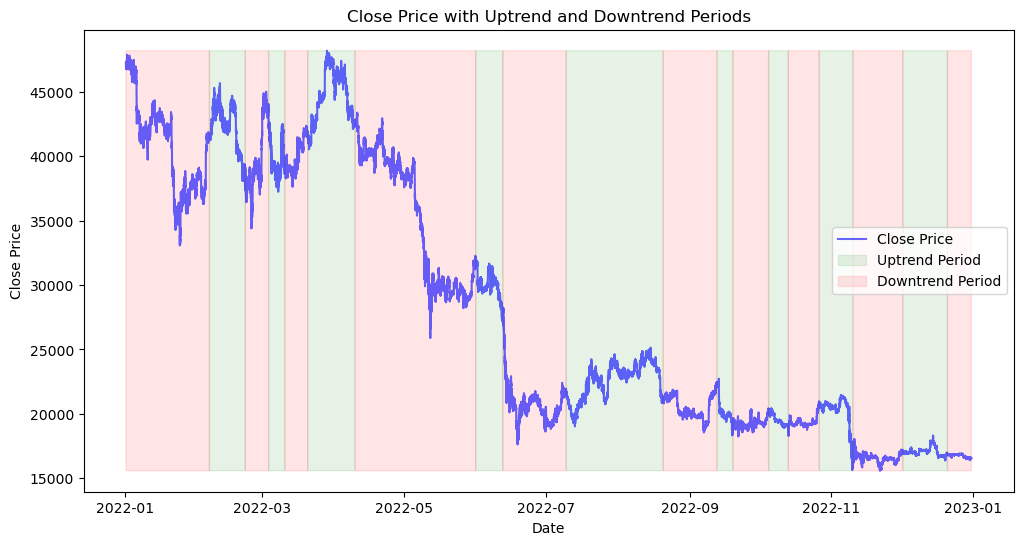

In [69]:
import matplotlib.pyplot as plt

# Define colors for trend periods
colors = {"uptrend": "green", "downtrend": "red"}

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_with_indicators.index, df_with_indicators["close"], label="Close Price", color="blue", alpha=0.6)

# Highlight uptrend and downtrend periods
for period, color in colors.items():
    plt.fill_between(
        df_with_indicators.index,
        df_with_indicators["close"].min(),
        df_with_indicators["close"].max(),
        where=df_with_indicators["Period"] == period,
        color=color,
        alpha=0.1,
        label=f"{period.capitalize()} Period",
    )

# Labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price with Uptrend and Downtrend Periods")
plt.legend()
plt.show()

Here, moving average crossovers are used to identify bull and bear markets. However, as seen in the chart, this method exhibits a certain degree of lag.

In [70]:
df_result['Period'] = df_with_indicators['Period']

In [71]:
evaluate_strategy(df_result[df_result['Period']=='uptrend'], risk_free_rate=0.0)

{'Sharpe Ratio': 0.01054305355987896,
 'Max Drawdown (%)': -12.41918803441735,
 'Holding Win Rate (%)': 10.125916899624878,
 'Trading Win Rate (%)': 74.67279801910152,
 'Final Cumulative Return (%)': 105.4374588272534}

In [72]:
evaluate_strategy(df_result[df_result['Period']=='downtrend'], risk_free_rate=0.0)

{'Sharpe Ratio': 0.01192412967557707,
 'Max Drawdown (%)': -14.250509448344411,
 'Holding Win Rate (%)': 10.324895988820783,
 'Trading Win Rate (%)': 74.51472939027175,
 'Final Cumulative Return (%)': 161.92709237656717}

### Analysis of the Strategy Performance

The results show that the trading strategy performs better in a **bear market** compared to a **bull market** despite the overall downward trend. This is likely due to the ability to **short-sell** in a declining market. However, in a **bull market**, the strategy struggles to capture small upward movements, indicating potential inefficiencies.

#### Key Observations:
1. **Higher Returns in Bear Market**  
   - The final cumulative return in the **downtrend** period is **161.93%**, significantly higher than the **105.43%** observed in the uptrend.
   - This suggests that the strategy effectively profits from price declines.

2. **Similar Trading Win Rate**  
   - The **trading win rate** remains stable (~74.6%) in both market conditions.
   - This implies that while individual trades are profitable, the overall performance is affected by the **trend-following nature** of the indicators.

3. **Higher Drawdown in Bear Market**  
   - The **max drawdown** in the downtrend period (-14.25%) is larger than in the uptrend (-12.42%).
   - This suggests that while the strategy performs well in bear markets, it also experiences deeper losses during unfavorable movements.

4. **Inefficiency in Capturing Small Upward Movements**  
   - The relatively **low Sharpe ratio** in both periods (0.0119 vs. 0.0105) suggests that risk-adjusted returns are not optimal.
   - The strategy might not be well-suited for capturing short-lived price rebounds within a broader market decline.

---

### Next Steps for Analysis

To improve the strategy, we will conduct further analysis in two key areas:

#### **1. Examining All Technical Indicators in Bull and Bear Markets**
   - We will analyze the performance of each **technical indicator** used in **Sub-strategy A** separately in **bull vs. bear markets**.
   - **Hypothesis:** Some indicators may exhibit **statistically significant differences** between the two market conditions.
   - **Statistical Test:**  
     - A potential method is conducting a **t-test** or **Mann-Whitney U test** to compare indicator effectiveness across different market conditions.  
     - Formula for a **two-sample t-test**:
$$
t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
$$

Where:
- $ \bar{X}_1, \bar{X}_2 $ are the mean returns in bull and bear markets.
- $ s_1^2, s_2^2 $ are variances in the two periods.
- $ n_1, n_2 $ are the sample sizes.


#### **2. Developing Detrended Technical Indicators**
   - Since **RSI and other indicators tend to work better in trending markets**, we will explore methods to **detrend** the data for improved performance across different market conditions.
   - **Proposed Method: Using Regression for Detrending**  
     - We will apply **linear regression** to remove trend components from price movements.
     - Formula for **trend normalization** using regression:
       $$
       y_i' = y_i - (\beta_0 + \beta_1 x_i)
       $$
       Where:
       - $ y_i' $ is the detrended price.
       - $ y_i $ is the original price.
       - $ \beta_0, \beta_1 $ are the intercept and slope from a linear regression on past price movements.
     - This should help indicators react more effectively to **relative price movements** rather than being affected by the **overall trend**.

---

### Conclusion

The findings highlight that while RSI and similar indicators can be profitable, they are highly dependent on market trends. Our next steps will focus on **evaluating individual indicators under different market regimes** and **designing detrended indicators** to improve robustness across market conditions.

## 5.5 Multi-Strategy Integration and Deterministic Weighting

The project combines signals from three sub-strategies (A, B, and C) using deterministic ensemble mechanisms. These methods aim to improve overall robustness and balance returns across diverse market conditions. Explicit evaluation metrics are employed during backtesting to quantify the weighted strategy’s realized performance and risk management.

---

### Sliding-Window Dynamic Weighting

Over a designated time window of length $T$, the returns (or accuracy) of each sub-strategy $A$, $B$, and $C$ are tracked. Periodically, their weights are updated based on performance. One example weighting scheme is:

$$
w_A(t) \;=\; \frac{\displaystyle \sum_{\tau=1}^{T} r_A(t-\tau)}{\displaystyle \sum_{i \in \{A,B,C\}} \sum_{\tau=1}^{T} r_i(t-\tau)},
$$

where $r_A(t-\tau)$ is the return (or accuracy score) of Sub-Strategy $A$ at time $t-\tau$. The weights $w_B(t)$ and $w_C(t)$ are computed analogously, and typically:

$$
w_A(t) \;+\; w_B(t) \;+\; w_C(t) \;=\; 1.
$$

---

### Voting Ensemble

1. **Consensus Strength**: When all three sub-strategies $A, B, C$ converge on the same trading direction (e.g., **Long** or **Short**), the ensemble increases position allocation.
2. **Divergence Handling**: If one sub-strategy diverges from the other two, the ensemble revises its final signal based on the diverging sub-strategy’s historical performance. For instance, a weighted vote could be computed as:

   $$
   S_{\text{ensemble}}(t) \;=\; \mathrm{sign}\Bigl(\,w_A(t)\, S_A(t) \;+\; w_B(t)\, S_B(t) \;+\; w_C(t)\, S_C(t)\Bigr),
   $$

   where $S_A(t)$, $S_B(t)$, and $S_C(t)$ are the directional signals (e.g., $\{-1, 0, +1\}$) from sub-strategies $A$, $B$, and $C$, respectively.

---

### Execution Engine Integration

The final composite signals are passed to a high-frequency execution module, which adheres to:
- **Slippage Handling**: Ensures minimal market impact by carefully routing orders.
- **Risk-Control Protocols**: Enforces capital protection, stop-loss mechanisms, and real-time monitoring.

This multi-strategy fusion approach augments the overall model’s robustness, balances returns across varying market conditions, and applies explicit evaluation metrics during backtesting to quantify both performance and risk.
